In [1]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import time

from envs import OfflineEnv
from recommender import DRRAgent

import os

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

#  Check Data

In [ ]:
#Loading datasets
ratings_list = pd.read_csv(r"dataset_csv\ratings.csv")
users_list = pd.read_csv(r"dataset_csv\users.csv")
movies_list = pd.read_csv(r"dataset_csv\movies.csv")
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings_df = ratings_df.astype({
    'UserID': np.uint32,
    'MovieID': np.uint32,
    'Rating': np.uint8,
    'Timestamp': np.uint32}) 
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [3]:
# moive id to movie title
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [4]:
# number of movies
len(movies_list)

3883

In [5]:
# check the ratings
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


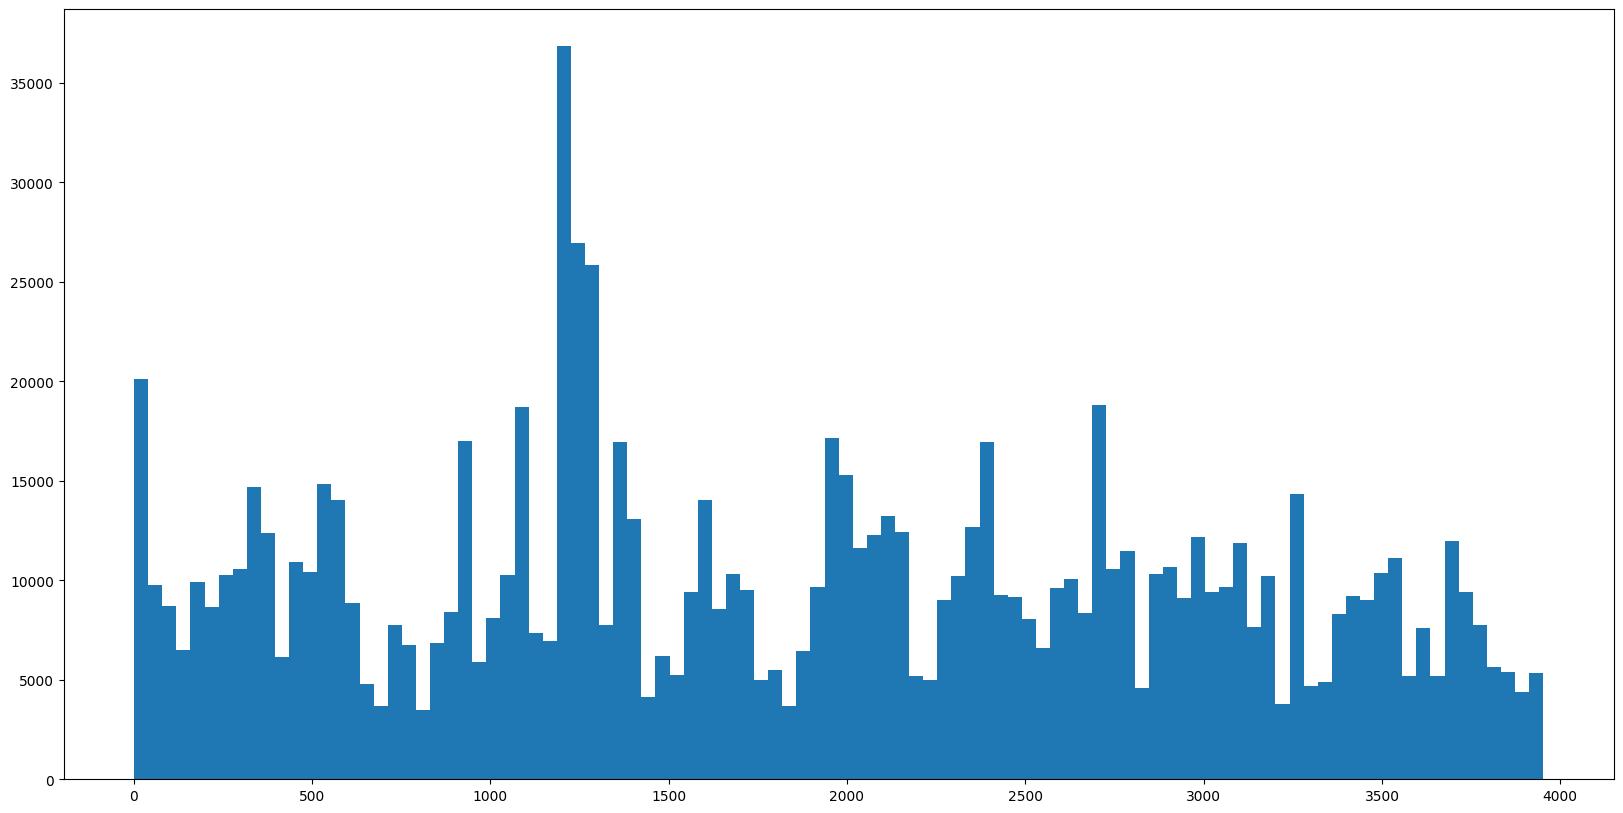

In [6]:
# check the distribution of movies choosen by user
plt.figure(figsize=(20,10))
plt.hist(ratings_df["MovieID"], bins=100)
plt.show()

In [7]:
# check null
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [8]:
# check the maximum value of UserID
print(len(set(ratings_df["UserID"])) == max([int(i) for i in set(ratings_df["UserID"])]))
print(max([int(i) for i in set(ratings_df["UserID"])]))

True
6040


In [9]:
# make suer the ratings are integer
ratings_df = ratings_df.applymap(int)

C:\Users\garvi\AppData\Local\Temp\ipykernel_17296\3532176190.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ratings_df = ratings_df.applymap(int)


In [10]:
# make the user dictionary which have a value as movies list the user watched
users_dict = {user : [] for user in set(ratings_df["UserID"])}
users_dict[1]

[]

In [11]:
# order the dataset by time
ratings_df = ratings_df.sort_values(by='Timestamp', ascending=True)
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
1000138,6040,858,4,956703932
999873,6040,593,5,956703954
1000153,6040,2384,4,956703954
1000007,6040,1961,4,956703977
1000192,6040,2019,5,956703977


In [12]:
# add (movie, rating) pair to the user dictionary
## add movie rated >= 4 only
ratings_df_gen = ratings_df.iterrows()
users_dict_for_history_len = {user : [] for user in set(ratings_df["UserID"])}
for data in ratings_df_gen:
    users_dict[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))
    if data[1]['Rating'] >= 4:
        users_dict_for_history_len[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))

In [13]:
# the length of history for each user
users_history_lens = [len(users_dict_for_history_len[u]) for u in set(ratings_df["UserID"])]

In [14]:
# check the length of above list
len(users_history_lens)

6040

In [15]:
# check the user dictionary
users_dict[1][:10]

[(np.int64(3186), np.int64(4)),
 (np.int64(1022), np.int64(5)),
 (np.int64(1721), np.int64(4)),
 (np.int64(1270), np.int64(5)),
 (np.int64(2340), np.int64(3)),
 (np.int64(1836), np.int64(5)),
 (np.int64(3408), np.int64(4)),
 (np.int64(1207), np.int64(4)),
 (np.int64(2804), np.int64(5)),
 (np.int64(260), np.int64(4))]

In [16]:
# save each data as npy to save time for future evaluation
np.save("./data/user_dict.npy", users_dict)
np.save("./data/users_histroy_len.npy", users_history_lens)

In [17]:
# get the number of users and items
users_num = max(ratings_df["UserID"])+1
items_num = max(ratings_df["MovieID"])+1

In [18]:
# check the following variables
print(users_num, items_num)

6041 3953


### setting for training dataset

In [19]:
train_users_num = int(users_num * 0.8)
train_items_num = items_num
print(train_users_num, train_items_num)

4832 3953


In [20]:
train_users_dict = {k:users_dict[k] for k in range(1, train_users_num+1)}
train_users_history_lens = users_history_lens[:train_users_num]
print(len(train_users_dict),len(train_users_history_lens))

4832 4832


### setting for evaluation dataset

In [21]:
eval_users_num = int(users_num * 0.2)
eval_items_num = items_num
print(eval_users_num, eval_items_num)

1208 3953


In [22]:
eval_users_dict = {k:users_dict[k] for k in range(users_num-eval_users_num, users_num)}
eval_users_history_lens = users_history_lens[-eval_users_num:]
print(len(eval_users_dict),len(eval_users_history_lens))

1208 1208


### the variables are ready
- users_dict
- users_history_len
- movies_id_to_movies
- users_num
- items_num

# Evalutation

In [23]:
def evaluate(recommender, env, check_movies = False, top_k=False):

    # episodic reward
    episode_reward = 0
    steps = 0
    mean_precision = 0
    mean_ndcg = 0
    # Environment
    user_id, items_ids, done = env.reset()
    if check_movies:
        print(f'user_id : {user_id}, rated_items_length:{len(env.user_items)}')
        print('history items : \n', np.array(env.get_items_names(items_ids)))

    while not done:

        # Observe current state & Find action
        ## Embedding 
        user_eb = recommender.embedding_network.get_layer('user_embedding')(np.array(user_id))
        items_eb = recommender.embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        ## SRM
        state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_eb, axis=0)])
        ## Action(ranking score) 
        action = recommender.actor.network(state)
        ## Item 
        recommended_item = recommender.recommend_item(action, env.recommended_items, top_k=top_k)
        if check_movies:
            print(f'recommended items ids : {recommended_item}')
            print(f'recommened items : \n {np.array(env.get_items_names(recommended_item), dtype=object)}')
        # Calculate reward & observe new state (in env)
        ## Step
        next_items_ids, reward, done, _ = env.step(recommended_item, top_k=top_k)
        if top_k:
            correct_list = [1 if r > 0 else 0 for r in reward]
            # ndcg
            dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(reward))])
            mean_ndcg += dcg/idcg
            
            #precision
            correct_num = top_k-correct_list.count(0)
            mean_precision += correct_num/top_k
            
        reward = np.sum(reward)
        items_ids = next_items_ids
        episode_reward += reward
        steps += 1
        
        if check_movies:
            print(f'precision : {correct_num/top_k}, dcg : {dcg:0.3f}, idcg : {idcg:0.3f}, ndcg : {dcg/idcg:0.3f}, reward : {reward}')
            print()
        break
    
    if check_movies:
        print(f'precision : {mean_precision/steps}, ngcg : {mean_ndcg/steps}, episode_reward : {episode_reward}')
        print()
    
    return mean_precision/steps, mean_ndcg/steps

def calculate_ndcg(rel, irel):
    dcg = 0
    idcg = 0
    rel = [1 if r>0 else 0 for r in rel]
    for i, (r, ir) in enumerate(zip(rel, irel)):
        dcg += (r)/np.log2(i+2)
        idcg += (ir)/np.log2(i+2)
    return dcg, idcg

In [24]:
# get the saved model dir
saved_actor = './save_model/trail-2022-12-13-04/actor_10_fixed.h5'
saved_critic = './save_model/trail-2022-12-13-04/critic_10_fixed.h5'

In [25]:
tf.keras.backend.set_floatx('float64')

In [26]:
TOP_K = 10 # chose any k value as you want

sum_precision = 0
sum_ndcg = 0

end_evaluation = 10

print(f"Evaluating users: {list(eval_users_dict.keys())[:end_evaluation+1]}")
print(f"# of eval users: {len(eval_users_dict)}")

for i, user_id in enumerate(eval_users_dict.keys()):
        env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=5501)
        recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
        recommender.actor.build_networks()
        recommender.critic.build_networks()
        recommender.load_model(
        "./save_model/fixed_trail/actor_fixed.weights.h5",
        "./save_model/fixed_trail/critic_fixed.weights.h5"
        )
        # recommender.load_model(saved_actor, saved_critic)
        precision, ndcg = evaluate(recommender, env, check_movies=True, top_k=TOP_K) # if check movies is true, you can check the recommended movies
        sum_precision += precision
        sum_ndcg += ndcg
        
        if i >= end_evaluation:
            break
        
        print(f'precision@{TOP_K} : {sum_precision/len(eval_users_dict)}, ndcg@{TOP_K} : {sum_ndcg/len(eval_users_dict)}')

Evaluating users: [4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843]
# of eval users: 1208


c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


user_id : 5501, rated_items_length:561
history items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
recommended items ids : [3424  912 2028  969 2716 1263 2863 2396 2791 1299]
recommened items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
precision : 0.8, dcg : 3.909, idcg : 4.544, ndcg : 0.860, reward : 5.5

precision : 0.8, ngcg : 0.8603818544462509, episode_reward : 5.5

precision@10 : 0.0006622516556291391, ndcg@10 : 0.0007122366344753733
user_id : 5501, rated_items_length:561
history items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
recommended items ids : [3424  912 2028  969 2716 1263 2863 2396 279

In [27]:
TOP_K = 10
sum_precision = 0
sum_ndcg = 0


end_evaluation = 15

eval_user_ids = list(eval_users_dict.keys())[:end_evaluation]

results = []

for i, user_id in enumerate(eval_user_ids):
    env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=user_id)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    recommender.load_model(
        "./save_model/fixed_trail/actor_fixed.weights.h5",
        "./save_model/fixed_trail/critic_fixed.weights.h5"
    )
    # Precision - % of time user liked the recommendation
    # Reward - -ve (wrt to actions suggested)
    # ndcg - right items in the top k positions (low - not ranked well)
    precision, ndcg = evaluate(recommender, env, check_movies=False, top_k=TOP_K)
    results.append((user_id, precision, ndcg))

# Show results in a clean table
import pandas as pd
df = pd.DataFrame(results, columns=["User ID", "Precision@10", "NDCG@10"])
display(df)


,User ID,Precision@10,NDCG@10
0,4833,0.6,0.645755
1,4834,0.5,0.460359
2,4835,0.3,0.208273
3,4836,0.2,0.158507
4,4837,0.2,0.129875
5,4838,0.0,0.000000
6,4839,0.0,0.000000
7,4840,0.1,0.085143
8,4841,0.4,0.349487
9,4842,0.3,0.199306


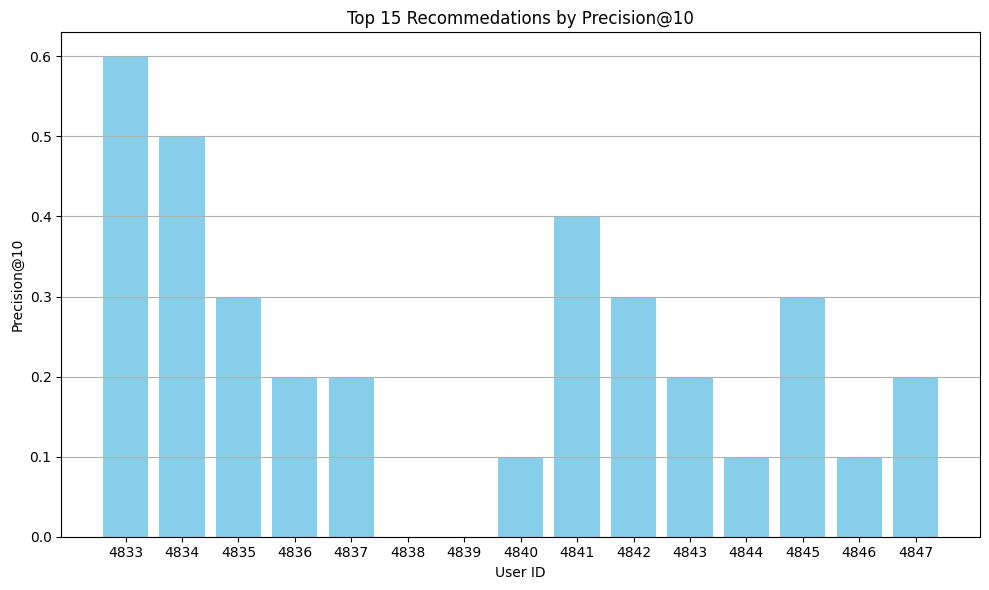

In [28]:
TOP_N = 15  # change to any number

# Sort by precision or NDCG
top_users = df

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(top_users["User ID"].astype(str), top_users["Precision@10"], color='skyblue')
plt.title(f"Top {TOP_N} Recommedations by Precision@10")
plt.xlabel("User ID")
plt.ylabel("Precision@10")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

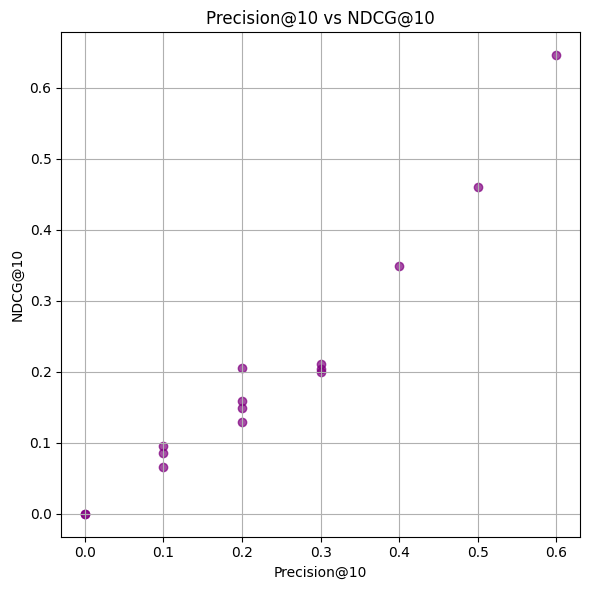

In [29]:
TOP_N = 15  # change to any number

# Sort by precision or NDCG
top_users = df

plt.figure(figsize=(6, 6))
plt.scatter(df["Precision@10"], df["NDCG@10"], color="purple", alpha=0.7)
plt.title("Precision@10 vs NDCG@10")
plt.xlabel("Precision@10")
plt.ylabel("NDCG@10")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# TOP_K = 10
# results = []
# eval_user_ids = list(eval_users_dict.keys())[:10]

# for i, user_id in enumerate(eval_user_ids):
#     env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=user_id)
#     recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
#     recommender.actor.build_networks()
#     recommender.critic.build_networks()
#     recommender.load_model(
#         "./save_model/fixed_trail/actor_fixed.weights.h5",
#         "./save_model/fixed_trail/critic_fixed.weights.h5"
#     )

#     precision, ndcg, recommended_titles = evaluate(env, recommender, movies_id_to_movies, top_k=TOP_K)
#     results.append((user_id, precision, ndcg, recommended_titles))


# import pandas as pd

# df = pd.DataFrame(results, columns=["User ID", "Precision@10", "NDCG@10", "Recommended Movies"])
# pd.set_option("display.max_colwidth", None)
# display(df)

c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


AttributeError: 'DRRAgent' object has no attribute 'reset'